In [1]:
import pandas as pd
import numpy as  np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


np.random.seed(42)

In [2]:
data = pd.read_csv('../data/processed/Data.csv', index_col=0)
X = data.copy()
y = X.pop('FBTP/NFBTP')

## Model Selection

- Seven models were chosen
- Calculate the combination of all features under different models
    - Recursive feature elimination(RFE) + cross validation (k=5)
    - Brute force calculation + cross validation

In [3]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest Classifier': RandomForestClassifier(),
    'XGBoost Classifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Decision Tree Classifier': DecisionTreeClassifier()
}

metrics = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1-Score': make_scorer(f1_score)
}


In [4]:
feature_score_cat = pd.read_csv("../data/external/feature_score_cat.csv")
feature_score = pd.read_csv("../data/external/feature_score_con.csv")


In [5]:
results = []

selected_features = pd.concat([feature_score_cat['feature'].head(20), feature_score['feature'].head(30)])
X_selected = X[selected_features]

for model_name, model in models.items():
    for num_features in range(1, 51):
        selector = RFE(model, n_features_to_select=num_features)
        selector = selector.fit(X_selected, y)
        selected_features_idx = selector.get_support(indices=True)
        X_transformed = X_selected.iloc[:, selected_features_idx]

        selected_feature_names = X_selected.columns[selected_features_idx].tolist()

        scores = {}
        for metric_name, metric in metrics.items():
            kf = KFold(n_splits=5) 
            score = cross_val_score(model, X_transformed, y, cv=kf, scoring=metric).mean()
            scores[metric_name] = score

        results.append({
            'Model': model_name,
            'Number of Features': num_features,
            'Selected Features': ', '.join(selected_feature_names), 
            **scores
        })

results_df_RFE = pd.DataFrame(results)
results_df_RFE.to_csv("../data/external/featureSelection_result_RFE.csv")

c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

### Brute force + cross val

In [11]:
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

np.random.seed(42)

models = {
    'K-Nearest Neighbor': KNeighborsClassifier(),
    'Support Vector Machines': SVC(probability=True),
    'Naive Bayes': GaussianNB()
}

metrics = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1-Score': make_scorer(f1_score)
}

kf = KFold(n_splits=5)

continuous_features = feature_score['feature'].head(30).tolist()
categorical_features = feature_score_cat['feature'].head(30).tolist()

results = []

for total_features in range(1, 51):  # Adjust the range to accommodate up to 50 features in total
    for cont_count in range(1, min(total_features, 31)):  # Ensure continuous features count does not exceed 30
        cat_count = total_features - cont_count
        if cat_count > 20:
            continue
        
        selected_features = continuous_features[:cont_count] + categorical_features[:cat_count]
        X_subset = X[selected_features]
        
        for model_name, model in models.items():
            scores = {}
            for metric_name, metric in metrics.items():
                score = cross_val_score(model, X_subset, y, cv=kf, scoring=metric).mean()
                scores[metric_name] = score
            
            results.append({
                'Model': model_name,
                'Number of Features': total_features,
                'Number of con': cont_count,
                'Number of cat': cat_count,
                **scores
            })

results_df_BF = pd.DataFrame(results)


c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

In [12]:
results_df_BF.to_csv("../data/external/featureSelection_result_BF.csv")

In [13]:
results_df_BF[results_df_BF['Model'] == 'Naive Bayes'].sort_values(by=['Precision','Recall'], ascending=[False, False])

Model  Number of Features  Number of con  Number of cat  Accuracy  \
140   Naive Bayes                  11              2              9      0.92   
170   Naive Bayes                  12              2             10      0.92   
383   Naive Bayes                  17              8              9      0.92   
590   Naive Bayes                  21              7             14      0.92   
605   Naive Bayes                  21             12              9      0.92   
...           ...                 ...            ...            ...       ...   
1052  Naive Bayes                  29              9             20      0.76   
410   Naive Bayes                  18              1             17      0.72   
461   Naive Bayes                  19              1             18      0.72   
515   Naive Bayes                  20              1             19      0.72   
572   Naive Bayes                  21              1             20      0.72   

      Precision    Recall  F1-Score  
140    0.950000  0.900000  0.904762  
170    0.950000  0.900000  0.904762  
383    0.950000  0.900000  0.904762  
590    0.950000  0.900000  0.904762  
605    0.950000  0.900000  0.904762  
...         ...       ...       ...  
1052   0.633333  0.633333  0.633333  
410    0.633333  0.566667  0.593333  
461    0.633333  0.566667  0.593333  
515    0.633333  0.566667  0.593333  
572    0.633333  0.566667  0.593333  

[600 rows x 8 columns]

Comparison

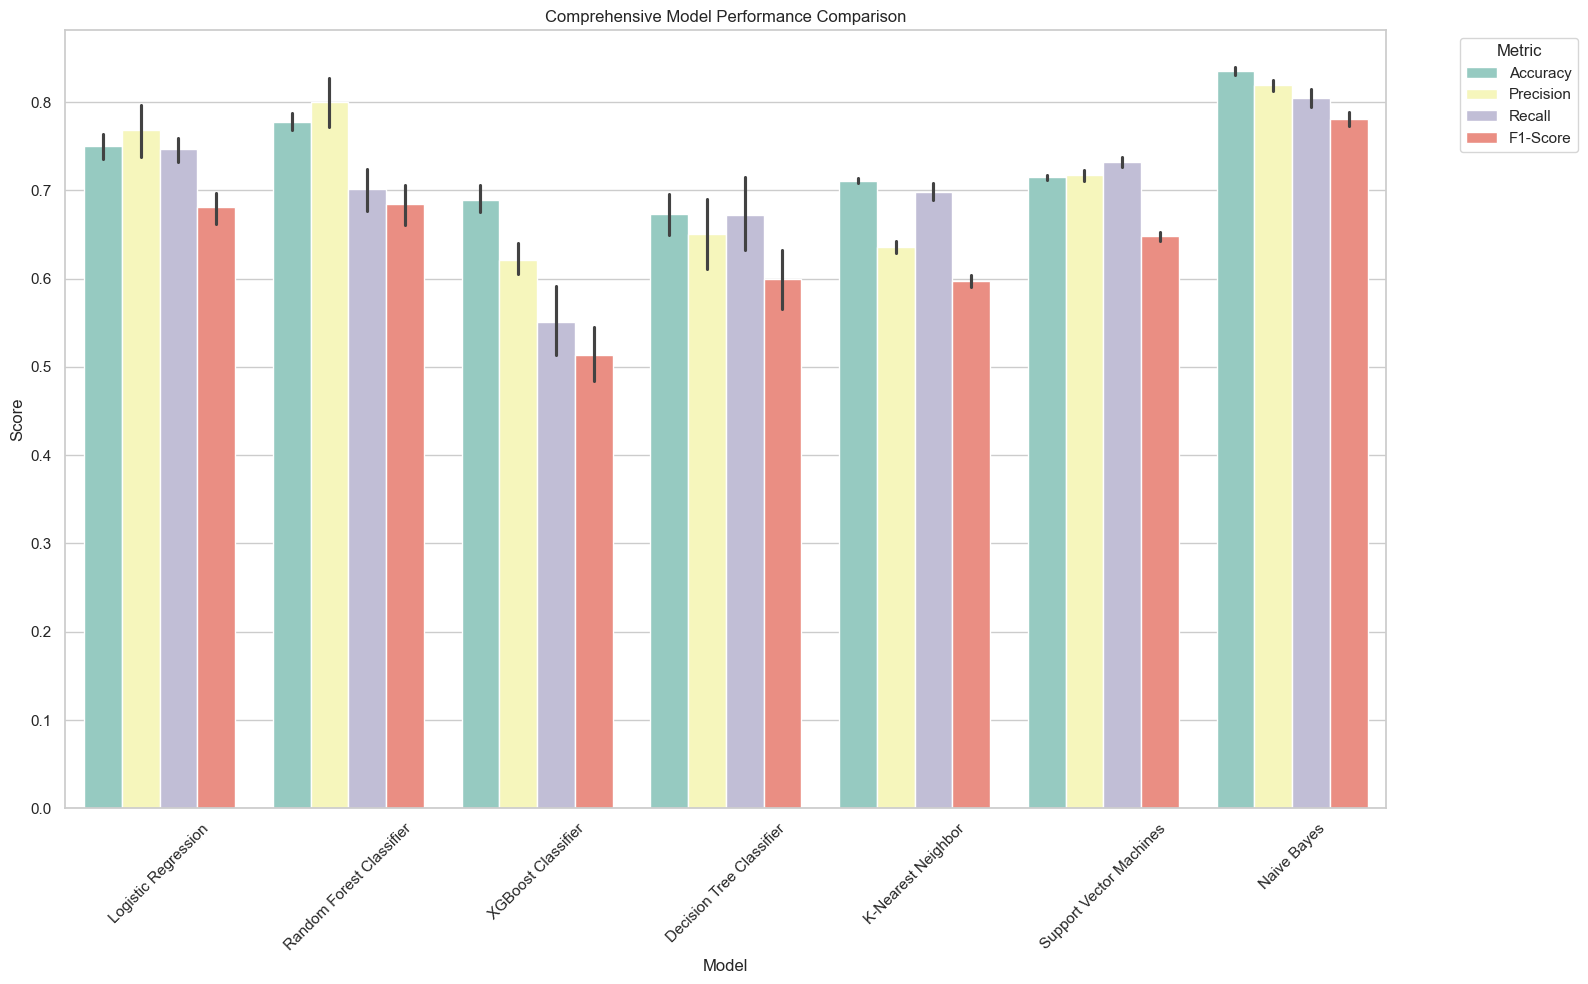

In [14]:
melted_df1 = results_df_RFE.melt(id_vars=['Model', 'Number of Features', 'Selected Features'],
                                 var_name='Metric', value_name='Score')
melted_df2 = results_df_BF.melt(id_vars=['Model', 'Number of Features', 'Number of con', 'Number of cat'],
                              var_name='Metric', value_name='Score')
combined_melted_df = pd.concat([melted_df1, melted_df2])

sns.set(style="whitegrid")


plt.figure(figsize=(16, 10))
sns.barplot(data=combined_melted_df, x='Model', y='Score', hue='Metric', palette='Set3')
plt.title('Comprehensive Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


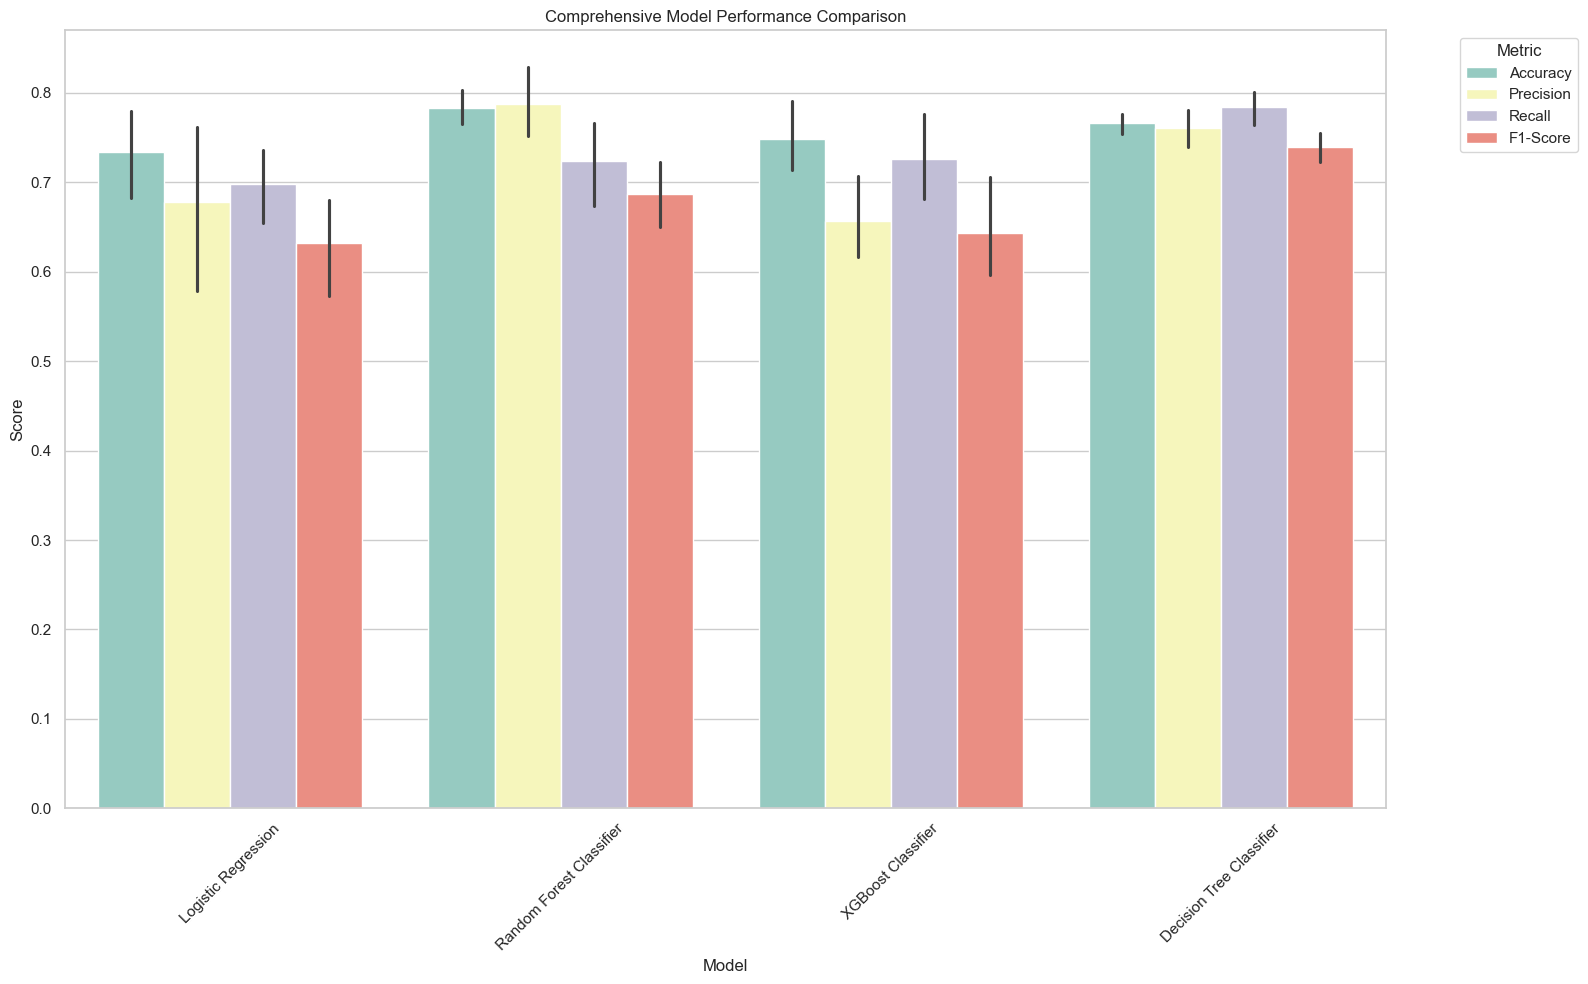

In [8]:
combined_melted_df_top15 = combined_melted_df[combined_melted_df['Number of Features'] < 15]
import seaborn as sns
import matplotlib.pyplot as plt

# 设置绘图风格
sns.set(style="whitegrid")

# 创建条形图
plt.figure(figsize=(16, 10))
sns.barplot(data=combined_melted_df_top15, x='Model', y='Score', hue='Metric', palette='Set3')
plt.title('Comprehensive Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

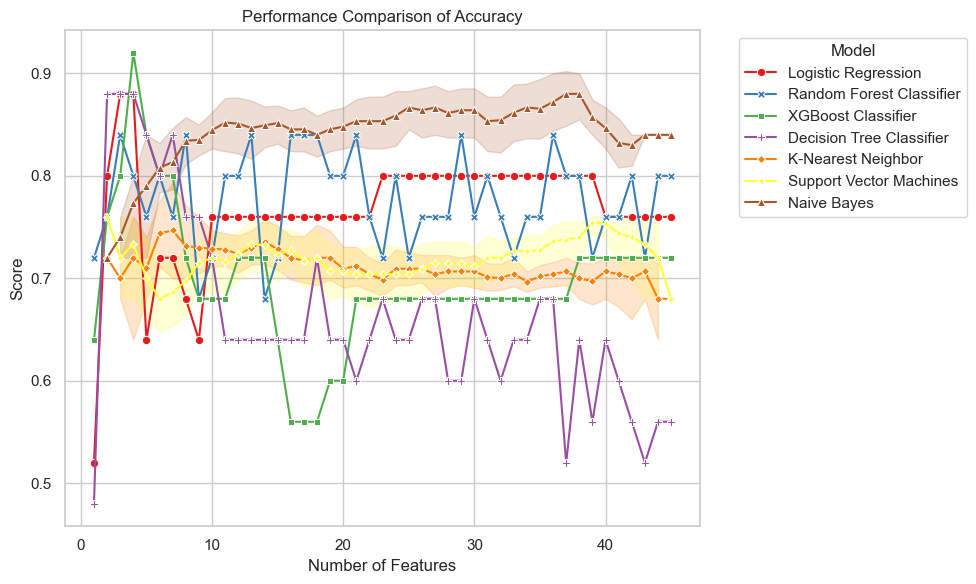

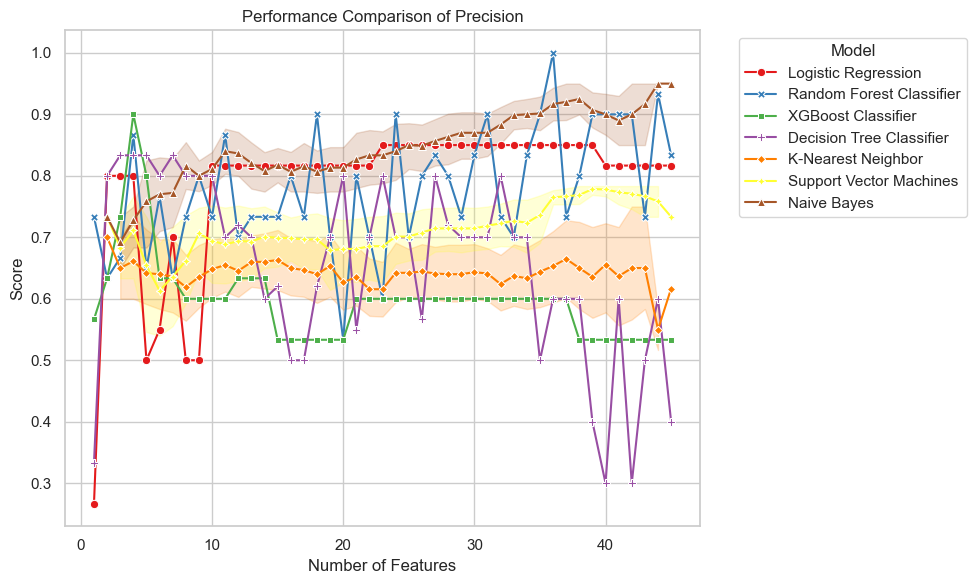

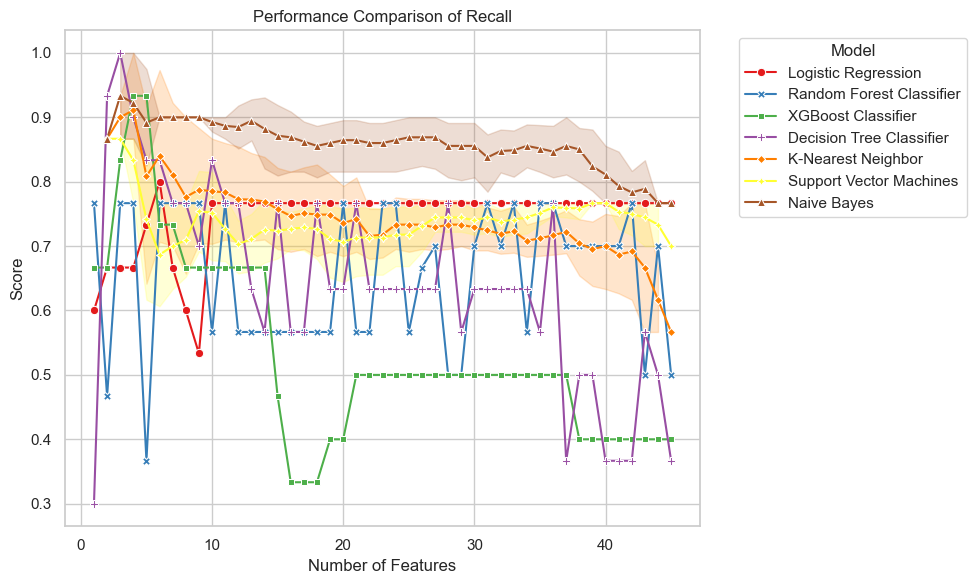

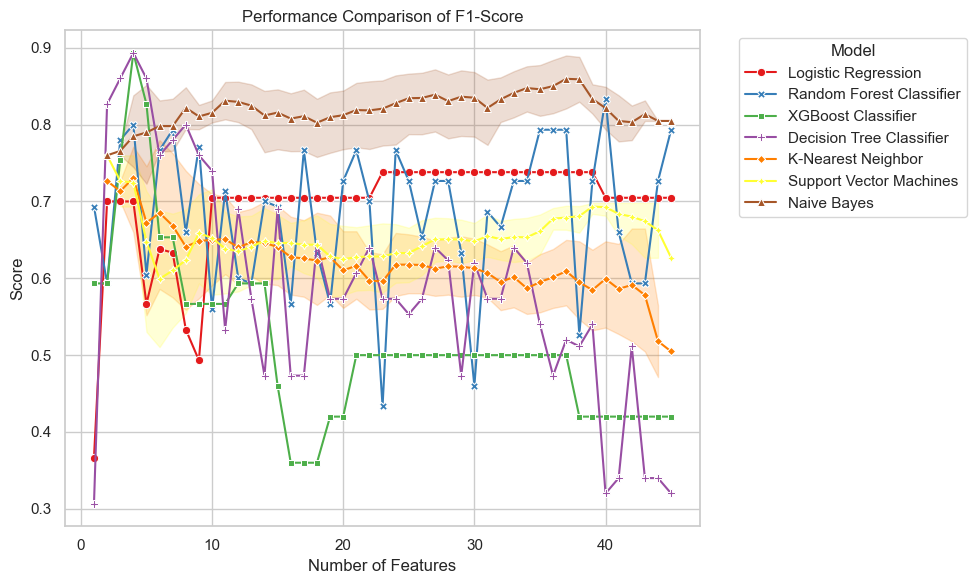

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置绘图风格
sns.set(style="whitegrid")

# 获取所有指标的唯一值
metrics = combined_melted_df['Metric'].unique()

# 对每个指标绘制一个图，图中包含所有模型的表现趋势
for metric in metrics:
    plt.figure(figsize=(10, 6))
    # 筛选当前指标的数据
    metric_data = combined_melted_df[combined_melted_df['Metric'] == metric]
    sns.lineplot(data=metric_data, x='Number of Features', y='Score', hue='Model', style='Model', markers=True, dashes=False, palette='Set1')
    plt.title(f'Performance Comparison of {metric}')
    plt.xlabel('Number of Features')
    plt.ylabel('Score')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)  # 显示网格线
    plt.tight_layout()
    plt.show()


### Conclusion

1.  Priority comparison recall, secondary comparison precision ->  LR, RF, DT, XGB
- **Precision**: Indicates the proportion of all samples predicted to be positive (effective in treatment) that are actually positive (effective in treatment). 
    - In the context of cancer treatment, this means that we don't give patients too much hope, if the model predicts that the treatment is effective, then there is a high probability that it will be effective.
- **Recall**: Indicates the proportion of all true positive samples that are correctly predicted as positive. 
    - In the context of cancer treatment, this means that we don't miss a single opportunity to treat patients that might be effective.

# Model Training

In [10]:
selected_features_rf = list(feature_score['feature'].head(20)) + list(feature_score_cat['feature'].head(20))

X_rf = X[selected_features_rf]

In [11]:
# Loo 未调整做参考

loo = LeaveOneOut()
y_true, y_pred, y_prob = [], [], []

for train_index, test_index in loo.split(X_rf):
    X_train, X_test = X_rf.iloc[train_index], X_rf.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]  # 获取属于正类的概率
    
    y_true.append(y_test.values[0])
    y_pred.append(predictions[0])
    y_prob.append(probabilities[0])

recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)  # 计算AUC

print(f"Leave-One-Out Cross-Validation Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")
print(f"AUC: {auc:.2f}")

feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X_rf.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Current model hyperparameters:")
print(model.get_params())

Leave-One-Out Cross-Validation Recall: 0.73
Precision: 0.80
F1 Score: 0.76
Accuracy: 0.80
AUC: 0.81
Current model hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [12]:
print(importance_df)

                            Feature  Importance
1          Pre-cure_Leukocytes(G/L)    0.093555
17         Max: g/ml_Choline_Kidney    0.070224
3      Std. dev: g/ml_Choline_Bone+    0.057419
9   Min: g/ml_Choline_SalivaryGland    0.053760
0         Pre-cure_Neutrophils(G/L)    0.052541
13        Std. dev: g/ml_PSMA_Bone-    0.051933
6         Peak: g/ml_Choline_Kidney    0.044780
12        Mean: g/ml_Choline_Kidney    0.044626
11             Max: g/ml_PSMA_Bone-    0.039794
4           Min: g/ml_Choline_Liver    0.038937
18          Min: g/ml_Choline_Bone+    0.037745
5      Std. dev: g/ml_Choline_Bone-    0.032601
23                     SubNumLN_Inv    0.031478
16         Mean: g/ml_Choline_Bone+    0.031222
15   Std. dev: g/ml_PSMA_LymphNode+    0.031145
2           Pre-cure_Liver_ALP(U/L)    0.030860
8          Pre-cure_Liver_ASAT(U/L)    0.028941
21            Difference_PSMA-FDG_1    0.026367
10                       Pelvis_Inv    0.022346
14          Pre-cure_Platelets(G/L)    0

随即搜索100轮

In [13]:
from sklearn.model_selection import RandomizedSearchCV, LeaveOneOut
from sklearn.metrics import roc_auc_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np


# 定义召回率评分器
precision_scorer = make_scorer(precision_score, zero_division=1)

# 模型和选择器设置
base_estimator = RandomForestClassifier(random_state=42)
selector = RFECV(estimator=base_estimator, step=1, cv=LeaveOneOut(), scoring='precision')

# 配置随机搜索参数
param_distributions = {
    'classifier__n_estimators': range(50, 201),
    'classifier__max_depth': [None] + list(range(5, 21)),
    'classifier__min_samples_split': range(2, 11),
    'classifier__min_samples_leaf': range(1, 6),
    'classifier__bootstrap': [True, False]
}

pipeline_extended = Pipeline([
    ('feature_selection', selector),
    ('classifier', base_estimator)
])

random_search = RandomizedSearchCV(
    estimator=pipeline_extended,
    param_distributions=param_distributions,
    n_iter=100,
    cv=LeaveOneOut(),
    scoring=precision_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# 执行搜索
random_search.fit(X_rf, y)

# 输出最佳参数
print("Best parameters found: ", random_search.best_params_)

# 计算和显示最佳模型的Recall和AUC
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_rf)
y_prob = best_model.predict_proba(X_rf)[:, 1]

final_precision = precision_score(y, y_pred, zero_division=0)
final_auc = roc_auc_score(y, y_prob)

print(f"Final Precision: {final_precision:.2f}")
print(f"Final AUC: {final_auc:.2f}")


Fitting 25 folds for each of 100 candidates, totalling 2500 fits


c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Best parameters found:  {'classifier__n_estimators': 166, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 3, 'classifier__max_depth': 17, 'classifier__bootstrap': False}
Final Precision: 0.89
Final AUC: 0.93


In [14]:
# 保存模型
import joblib
joblib.dump(best_model, 'best_model_random.pkl')

['best_model_random.pkl']

网格搜索

In [15]:
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
import joblib
import pandas as pd
from sklearn.metrics import make_scorer, recall_score, roc_auc_score, precision_score, f1_score, accuracy_score
from tqdm import tqdm

# 设置基础模型和参数
base_estimator = RandomForestClassifier(random_state=42)
selector = RFECV(estimator=base_estimator, step=1, cv=LeaveOneOut(), scoring='precision')

param_grid_extended = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 4, 6],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

pipeline_extended = Pipeline([
    ('feature_selection', selector),
    ('classifier', base_estimator)
])

recall_scorer = make_scorer(recall_score, zero_division=0)
grid_search_extended = GridSearchCV(
    estimator=pipeline_extended,
    param_grid=param_grid_extended,
    cv=LeaveOneOut(),
    scoring=precision_scorer,
    n_jobs=-1,
    verbose=2
)


In [16]:
# 模型训练
grid_search_extended.fit(X_rf, y)

# 保存模型和输出最佳参数
print("Best parameters found (extended): ", grid_search_extended.best_params_)
joblib.dump(grid_search_extended.best_estimator_, 'best_model_grid.pkl')

Fitting 25 folds for each of 216 candidates, totalling 5400 fits


c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Best parameters found (extended):  {'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}


['best_model_grid.pkl']

In [17]:
# 重新评估最佳模型以获取各项指标
best_model = grid_search_extended.best_estimator_

y_true, y_pred_list, y_prob_list = [], [], []
for train_index, test_index in tqdm(LeaveOneOut().split(X_rf), total=X_rf.shape[0], desc="Evaluating model"):
    X_train, X_test = X_rf.iloc[train_index], X_rf.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[0][1]
    y_true.append(y_test.item())
    y_pred_list.append(y_pred.item())
    y_prob_list.append(y_prob)

final_recall = recall_score(y_true, y_pred_list, zero_division=0)
final_precision = precision_score(y_true, y_pred_list, zero_division=0)
final_f1 = f1_score(y_true, y_pred_list, zero_division=0)
final_accuracy = accuracy_score(y_true, y_pred_list)
final_auc = roc_auc_score(y_true, y_prob_list)

print(f"Recall: {final_recall:.2f}")
print(f"Precision: {final_precision:.2f}")
print(f"F1 Score: {final_f1:.2f}")
print(f"Accuracy: {final_accuracy:.2f}")
print(f"AUC: {final_auc:.2f}")

Evaluating model:   0%|          | 0/25 [00:00<?, ?it/s]c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\86187\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this b

Recall: 0.45
Precision: 0.56
F1 Score: 0.50
Accuracy: 0.60
AUC: 0.57
